# 3D U-Net 
This Jupyter notebook contains the following processes about 3D U-Net:

* Number of parameters (Model complexity)
* Hyperparameter Tuning 
* Training and Test Evaluation

In [2]:
# Import necessary libraries
import numpy as np
import torchio as tio
from torchinfo import summary

# Custom modules containing my implementation of the models with PyTorch and also some helper functions
from models.unet3d import UNet
from model_utils.train_eval import *
from data_utils.dataset import *
from model_utils.metrics import plot_val_per_epoch, get_train_time

In [2]:
sample_unet = UNet(1)
summary(sample_unet, (2,1,40,56,72))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [2, 1, 40, 56, 72]        --
├─ModuleList: 1-1                        --                        1,660,608
│    └─Sequential: 2-1                   [2, 64, 40, 56, 72]       --
│    │    └─Conv3d: 3-1                  [2, 32, 40, 56, 72]       896
│    │    └─BatchNorm3d: 3-2             [2, 32, 40, 56, 72]       64
│    │    └─ReLU: 3-3                    [2, 32, 40, 56, 72]       --
│    │    └─Conv3d: 3-4                  [2, 64, 40, 56, 72]       55,360
│    │    └─BatchNorm3d: 3-5             [2, 64, 40, 56, 72]       128
│    │    └─ReLU: 3-6                    [2, 64, 40, 56, 72]       --
├─MaxPool3d: 1-2                         [2, 64, 20, 28, 36]       --
├─ModuleList: 1-1                        --                        1,660,608
│    └─Sequential: 2-2                   [2, 128, 20, 28, 36]      --
│    │    └─Conv3d: 3-7                  [2, 64, 20, 28, 36]     

#### Train-test split

In [4]:
train_subj, test_subj = get_train_test_subjects(
    'harp_metadata.csv',  # change accordingly to where this file is stored
    'znorm_cropped_imgs',  # change accordingly to where this folder is stored
    42, # fix the split
    True
)

#### LR Range Test for 3D U-Net$_L$ and 3D U-Net$_R$

As explained in: https://arxiv.org/pdf/1506.01186.pdf

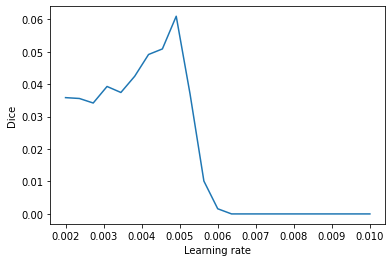

In [12]:
lr_test_unet = UNet(1)
lr_test_hist = lr_range_test(
    lr_test_unet,
    'znorm_cropped_imgs',
    'L',
    train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    end_lr=0.01
)

lr_range_plot(lr_test_hist, 'metric')

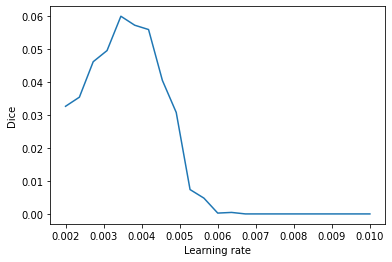

In [26]:
lr_test_unet = UNet(1)
lr_test_hist = lr_range_test(
    lr_test_unet,
    'znorm_cropped_imgs',
    'R',
    train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    end_lr=0.01
)

lr_range_plot(lr_test_hist, 'metric')

$LR_{max}$ for 3D U-Net$_L$ = 0.005

$LR_{max}$ for 3D U-Net$_R$ = 0.0035

#### Hyperparameter Tuning for 3D U-Net

For conciseness of this notebook, we will only use one experiment cell each for the left and right hippocampus respectively. However, I strongly recommend to not run these cells because they will take up significant time especially if you do not have a high memory GPU.

The cross validation plots ran in our experiments can be obtained by loading the cross validation histories from the "saved_histories" folder.

In [ ]:
# DO NOT run unless connected to GPU
trainval_hist_3d_L_b2_e50 = skfcv_train_model(
    model_class = UNet,
    dir_name='znorm_cropped_imgs',
    brain_side='L',
    meta_file='harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.005,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_3d_L_b2_e50.npz', **trainval_hist_3d_L_b2_e50)

In [ ]:
# DO NOT run unless connected to GPU
trainval_hist_3d_R_b2_e50 = skfcv_train_model(
    model_class = UNet,
    dir_name='znorm_cropped_imgs',
    brain_side='R',
    meta_file='harp_metadata.csv',
    train_ids=train_subj,
    transforms=[
        tio.RandomNoise(),
        tio.OneOf({
            tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
            tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
        })
    ],
    batch_size=2,
    num_epochs=50,
    max_learn_rate=0.0035,
    kfold=5,
    random_seed=41
)

np.savez('trainval_hist_3d_R_b2_e50.npz', **trainval_hist_3d_R_b2_e50)

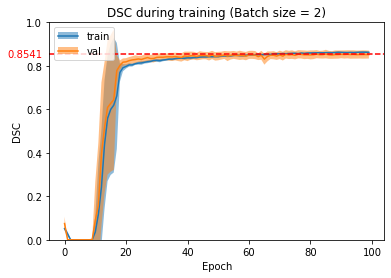

Per epoch training time = 8.830954766000001


In [3]:
## Plotting of cross validation outputs from saved histories

model_type='3d'
brain_side='L'
batch_size=2
num_epoch=100

trainval_hist = np.load('saved_histories/{0}_{2}/trainval_hist_{1}_{2}_b{3}_e{4}.npz'.format(
    model_type.upper(), 
    model_type,
    brain_side,
    batch_size,
    num_epoch
)
                       )

trainval_hist = dict(trainval_hist)

plot_val_per_epoch(trainval_hist,
                   [('train_dice_per_epoch', 'train'), ('val_dice_per_epoch', 'val')],
                  'DSC',
                  'DSC during training (Batch size = {0})'.format(batch_size),
                  (0.0, 1))

print("Per epoch training time = {0}".format(get_train_time(trainval_hist, per_epoch=True, kfcv=True)))

##### Hyperparameter Tuning Results

Final hyperparameters for 3D U-Net$_L$:
* $LR_{max}$ = 0.005
* Mini-batch size = 2
* Number of epochs = 50

Final hyperparameters for 3D U-Net$_R$:
* $LR_{max}$ = 0.0035
* Mini-batch size = 2
* Number of epochs = 60

#### Training on full training data and Evaluation

Strongly suggest to not uncomment and run the training cell if you are not using a device with GPU access (to prevent any crashes). The models trained have been saved under the "saved_models" folder as .pth files. Load those instead to prevent any errors due to absence of GPU or a GPU with insufficient memory.

In [28]:
finalUNet_L = UNet(1)
finalUNet_R = UNet(1)

In [ ]:
# WARNING, running without a 16GB memory GPU has not been tested, 
# highly recommended to skip this cell and load the saved models to prevent any system errors
# due to hardware constraints.

# train_history_L = train_model(
#     model=finalUNet_L,
#     dir_name='znorm_cropped_imgs',
#     brain_side='L',
#     train_ids=train_subj,
#     transforms=[
#         tio.RandomNoise(),
#         tio.OneOf({
#             tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
#             tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
#         })
#     ],
#     batch_size=2,
#     num_epochs=60,
#     max_learn_rate=0.005
# )

# train_history_R = train_model(
#     model=finalUNet_R,
#     dir_name='znorm_cropped_imgs',
#     brain_side='R',
#     train_ids=train_subj,
#     transforms=[
#         tio.RandomNoise(),
#         tio.OneOf({
#             tio.RandomAffine(scales=(0.9, 1.1), degrees=5): 0.5,
#             tio.RandomElasticDeformation(num_control_points=5, max_displacement=7.5, locked_borders=2): 0.5
#         })
#     ],
#     batch_size=2,
#     num_epochs=60,
#     max_learn_rate=0.0035
# )

# np.savez('final_3D_L_trainhist.npz', **train_history_L)
# save_model(finalUNet_L, save_path='final_3D_L.pth')

# np.savez('final_3D_R_trainhist.npz', **train_history_R)
# save_model(finalUNet_R, save_path='final_3D_R.pth')

In [ ]:
# Load the saved models
finalUNet_L.load_state_dict(torch.load('saved_models/final_3D_L.pth'))
finalUNet_L.to('cuda')

finalUNet_R.load_state_dict(torch.load('saved_models/final_3D_R.pth'))
finalUNet_R.to('cuda')

Evaluation of 3D U-Net models on test subjects is done in the below cell. Replace the test_ids argument in the start_eval function with 'ad_test_subj' to get test performance on AD subjects. Same goes for MCI and CN test subjects.

In [33]:
# Evaluation on test data
# Best to run on a machine with GPU as well

ad_test_subj = ['123_S_0091','098_S_0149','067_S_0812',
               '023_S_0916','020_S_0213','018_S_4696',
               '011_S_0010','005_S_1341','002_S_0938']
mci_test_subj = ['123_S_1300','100_S_0006','094_S_1293',
                 '012_S_1292','007_S_0128','005_S_0448',
                 '003_S_0908','002_S_0782']
cn_test_subj = ['127_S_0259','100_S_0015','032_S_0479',
                '018_S_0425','010_S_0419','010_S_0067',
                '002_S_0413','002_S_0295']

test_loss_L, test_dsc_L, test_prec_L, test_recall_L = start_eval(model=finalUNet_L,
                                                                 dir_name='znorm_cropped_imgs',
                                                                 brain_side='L',
                                                                 test_ids=test_subj, 
                                                                 batch_size=1, 
                                                                 verbose=False)

test_loss_R, test_dsc_R, test_prec_R, test_recall_R = start_eval(model=finalUNet_R, 
                                                                 dir_name='znorm_cropped_imgs', 
                                                                 brain_side='R',
                                                                 test_ids=test_subj, 
                                                                 batch_size=1, 
                                                                 verbose=False)

print("## Left hippocampus ##")
print("Test Loss: {0:.5f}, Test DSC: {1:.5f}, Test Precision: {2:.5f}, Test Recall: {3:.5f}".format(
    test_loss_L,
    test_dsc_L,
    test_prec_L,
    test_recall_L)
     )
print('## Right hippocampus ##')
print("Test Loss: {0:.5f}, Test DSC: {1:.5f}, Test Precision: {2:.5f}, Test Recall: {3:.5f}".format(
    test_loss_R,
    test_dsc_R,
    test_prec_R,
    test_recall_R)
     )

## Left hippocampus ##
Test Loss: 0.01282, Test DSC: 0.86155, Test Precision: 0.88132, Test Recall: 0.84950
## Right hippocampus ##
Test Loss: 0.01326, Test DSC: 0.86604, Test Precision: 0.87576, Test Recall: 0.86122


In [7]:
# Total training time
final_3D_L_hist = dict(np.load("saved_histories/final_3D_L/final_3D_L_trainhist.npz"))
final_3D_R_hist = dict(np.load("saved_histories/final_3D_R/final_3D_R_trainhist.npz"))
print("## 3D U-Net for left hippocampus ##")
print("Total training time = {0}".format(get_train_time(final_3D_L_hist, per_epoch=False, kfcv=False)))
print("## 3D U-Net for right hippocampus ##")
print("Total training time = {0}".format(get_train_time(final_3D_R_hist, per_epoch=False, kfcv=False)))

## 3D U-Net for left hippocampus ##
Total training time = 515.595418
## 3D U-Net for right hippocampus ##
Total training time = 623.277448


#### Generate predicted segmentation masks

The model_predict function generates a new NIfTI file that contains the predicted hippocampus segmentation mask. The code in the below cell was used to generate the prediction for subject 011_S_0010's left hippocampus using the 3D U-Net. It is stored inside the folder 'znorm_cropped_imgs/011_S_0010/' with the file name 'PRED_LH_011_S_0010.nii'. 

This segmentation can be interactively visualized using medical imaging software. In this thesis, ITK-Snap was used (http://www.itksnap.org/pmwiki/pmwiki.php) for visualization purposes, however other software such as FSL and FreeSurfer should work fine as well.

In [ ]:
net3d = UNet(1)

model_predict(
    model=net3d,
    dir_name='znorm_cropped_imgs',
    subj_id='011_S_0010',
    brain_side='L',
    model_file='saved_models/final_3D_L.pth'
)